# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [11]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikitaermishov. Use `wandb login --relogin` to force relogin


True

In [2]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm_notebook as tqdm

# You may add any imports you need
import warnings
warnings.filterwarnings("ignore")
import cv2
import copy
from torch.utils.data import Dataset
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Connected device is {device}')

Connected device is cuda


In [3]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [15]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-03 08:37:49--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-03 08:37:50--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf70e00cd7d79742eb7679745d7.dl.dropboxusercontent.com/cd/0/get/BwC-B5vUSPAEhezjeAe-LmY2lZlQ99YcqRCszbqxVnbj6v7KMKZMVLnn7qeno_RkTZ5t0X5sbtEFSRk4GStB3UaYyOFIm1BrFP1pWHz4odTw2eFb2AR-l44tNcbi-GSJgwNN-tARcAihID3BdkqA4SR9_4B7BhquzG7BUN120fYVmw/file?dl=1# [following]
--2022-11-03 08:37:50--  https://ucf70e00cd7d79742eb7679745d7.dl.dropboxusercontent.com/cd/0/get/BwC-B5vUSPAEhezjeAe-LmY2lZlQ99YcqRCszbqxVnbj6v7KMKZMVLnn7qeno_RkTZ5t0X5sbtEFSRk4G

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [4]:
# YOU CAN DEFINE AUGMENTATIONS HERE
probability = .5
train_transform = A.Compose(
    [
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=probability),
        A.RandomBrightnessContrast(p=probability),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.1),
        A.HorizontalFlip(p=probability),
        A.Sharpen(p=probability),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

In [5]:
from pandas.core.common import flatten
# dataset_path = './dataset'
# train_path = os.path.join(dataset_path, 'train')
# val_path = os.path.join(dataset_path, 'val')

# for colab
train_path = '/content/dataset/dataset/train'
val_path = '/content/dataset/dataset/val'

train_image_paths = []
val_image_paths = []
classes = []

for train_data_path, val_data_path in tqdm(zip(os.listdir(val_path), os.listdir(train_path))):
    train_data_path = os.path.join(train_path, train_data_path)
    val_data_path = os.path.join(val_path, val_data_path)
    
    train_image_list = [os.path.join(train_data_path, path) for path in os.listdir(train_data_path)]
    val_image_list = [os.path.join(val_data_path, path) for path in os.listdir(val_data_path)]

    classes.append(train_data_path.split('/')[-1]) 
    train_image_paths.append(train_image_list)
    val_image_paths.append(val_image_list)

print('initialization was completed!\n')

train_image_paths = list(flatten(train_image_paths))
val_image_paths = list(flatten(val_image_paths))

random.shuffle(train_image_paths)

print(f'number of train objects: {train_image_paths.__len__()},\
      \nnumber of val objects: {val_image_paths.__len__()}')

0it [00:00, ?it/s]

initialization was completed!

number of train objects: 100000,      
number of val objects: 10000


In [6]:
indices_to_classes = {i:j for i, j in enumerate(classes)}
classes_to_indices = {value:key for key,value in indices_to_classes.items()}

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = classes_to_indices[label]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label
    
    def __len__(self):
        return len(self.image_paths)

In [8]:
train_dataset = CustomDataset(train_image_paths,
                           transform=train_transform)
val_dataset = CustomDataset(val_image_paths,
                         transform=val_transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False
)

In [9]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

In [10]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random=True):
    dataset = copy.deepcopy(dataset)
    dataset.transform.transforms = A.Compose([t for t in dataset.transform.transforms if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        if random:
            idx = np.random.randint(1,len(train_image_paths))
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(indices_to_classes[_])
    plt.suptitle('Applied augmentations to different classes', fontweight='bold')
    plt.tight_layout()
    plt.show()

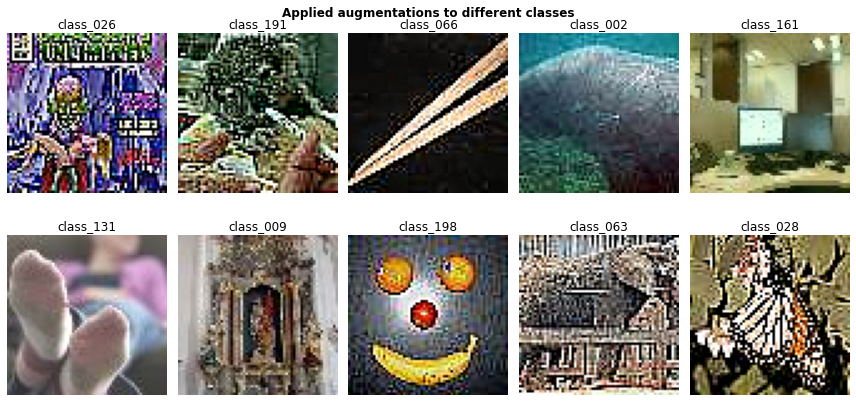

In [11]:
visualize_augmentations(dataset=train_dataset)

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [12]:
class YourNet(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(YourNet, self).__init__()
        
        self.model = torchvision.models.densenet121(pretrained=False, 
                                                     num_classes=200)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        return self.model(x)

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss
    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

In [13]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        
    def forward(self, x):
        result = self.model(x)

        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            params=self.parameters(), 
            lr=self.learning_rate,
            weight_decay=0.0001,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=1,
            verbose=True
        )
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
       }

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log('train_loss', loss, prog_bar=True)
        sch = self.lr_schedulers()

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log('val_loss', loss, prog_bar=True)

In [14]:
wandb_logger = WandbLogger(log_model='all')

model = YourNet().to(device)
module = YourModule(
    model,
    learning_rate = 0.001
)

In [15]:
seed_everything(123456)
trainer = pl.Trainer(logger=wandb_logger,
                     accelerator='gpu',
                     max_epochs=20,
                     auto_lr_find=True,
                     log_every_n_steps=60,
                     )
trainer.fit(module, train_dataloader, val_dataloader, ckpt_path='/content/checkpoints/epoch=12-step=5083.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/epoch=12-step=5083.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | YourNet | 7.2 M 
----------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/checkpoints/epoch=12-step=5083.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 391it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Валидация результатов задания

In [16]:
torch.save(model.state_dict(), '/content/wnb/DenseNet121(2.149val_loss).pth') # я дурачок, я по кнопке промахнулся и тут лосс 2.140, это видно выше, да и по ссылке снизу.

In [20]:
model = YourNet().to(device)
model.load_state_dict(torch.load('/content/wnb/DenseNet121(2.149val_loss).pth'))

<All keys matched successfully>

In [21]:
from sklearn.metrics import accuracy_score
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model._forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [25]:
accuracy = evaluate_task(model, val_dataloader)
print(100*accuracy)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

  0%|          | 0/40 [00:00<?, ?it/s]

48.339999999999996
Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [7]:
probability = .5
train_transform_pretrained_model = A.Compose(
    [   
        A.Resize(height=255, width=255),
        A.CenterCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=probability),
        A.RandomBrightnessContrast(p=probability),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.1),
        A.HorizontalFlip(p=probability),
        A.Sharpen(p=probability),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

val_transform_pretrained_model = A.Compose(
    [   
        A.Resize(height=255, width=255),
        A.CenterCrop(height=224, width=224),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

In [8]:
train_dataset_pretrained = CustomDataset(train_image_paths,
                           transform=train_transform_pretrained_model)
val_dataset_pretrained = CustomDataset(val_image_paths,
                         transform=val_transform_pretrained_model)

train_dataloader_pretrained = DataLoader(
    train_dataset_pretrained,
    batch_size=64,
    shuffle=True
)
val_dataloader_pretrained = DataLoader(
    val_dataset_pretrained,
    batch_size=64,
    shuffle=False
)

### Тренировочный класс lightning

In [9]:
from functools import partial
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2)
        return x

In [10]:
class YourNet(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(YourNet, self).__init__()
        
        self.model = torchvision.models.convnext_base(weights='DEFAULT') 
        self.model.classifier = nn.Identity() 
        norm_layer = partial(nn.LayerNorm, eps=1e-6)
        self.classifier = nn.Sequential(
            norm_layer([1024, 1, 1]),
            nn.Flatten(1),
            nn.Linear(in_features=1024, out_features=200, bias=True)
        )
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        with torch.no_grad(): 
            features = self.model(x)
        preds = self.classifier(features)
        return preds
        
        return out

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss
    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [11]:
class YourModule(pl.LightningModule):
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.classifier.parameters(),
                                          weight_decay=0.0001)
        self.save_hyperparameters()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        
        return self.optimizer
       

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log('train_loss', loss, prog_bar=True)
        sch = self.lr_schedulers()

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log('val_loss', loss, prog_bar=True)

In [12]:
wandb_logger = WandbLogger(log_model='all')

model = YourNet().to(device)
module = YourModule(
    model
)

In [13]:
seed_everything(123456)
trainer = pl.Trainer(logger=wandb_logger,
                     accelerator='gpu',
                     max_epochs=5,
                     log_every_n_steps=60,
                     ) 
trainer.fit(module, train_dataloader_pretrained, val_dataloader_pretrained)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | YourNet | 87.8 M
----------------------------------
87.8 M    Trainable params
0         Non-trainable params
87.8 M    Total params
351.086   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
torch.save(model.state_dict(), '/content/wnb/ConvNeXt(0.645val_loss).pth')

In [ ]:
model = YourNet().to(device)
model.load_state_dict(torch.load('/content/wnb/ConvNeXt(0.645val_loss).pth'))

### Валидация результатов задания

In [17]:
accuracy = evaluate_task(model, val_dataloader_pretrained)
print(100*accuracy)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

  0%|          | 0/157 [00:00<?, ?it/s]

83.33
Оценка за это задание составит 9.80 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

* В этом задании крайне помогло изменение batch_size, с 2048 до 256, потому что я могу использовать более тяжелые сетки для выполнения задания.
* Почему-то я сразу нарвался на DenseNet121, которая изначально не влезала, но с изменение batch_size, у меня вышло.
* Я понял сразу, что эта сетка может себя показать, потому что:
    1. У нее неплохие результаты в статьях о замере сеток на Imagenet.
    2. Она довольно легковесная, типо 7млн. параметров еще не так много.
* Во втором задании мой выбор пал на ConvNeXt в базовом варианте, потому что меня пугали размеры других сетей, по типу RegNet'a, у которых там под 600млн. параметров, а accuracy выше всего на 4%. Тут я пытался сначала потестить без LayerNorm2d'a, резы были неплохие (кину ссылку на wandb), но я подумал не зря же у них в source стоит этот LayerNorm2d, сначала я почитал, сделал кастомный и на трейне очень хорошо себя повел, но на валидации что-то он хромал, потом я все-таки взял LayerNorm2d с recipe ConvNeXt'a и не прогадал.
* Также в этом задании очень помогли аугментации, большую часть из них я подглядел либо в гайде библиотеки, либо на гитхабе у разрабов сеток (хотя большинство из них много аугментаций не юзало, но я запотел).
* Ну и последнее, что я хотел бы сказать, это то, что batch_size во втором задании был также взят с recipe ConvNeXt'a.


А ну и у меня постоянно кончалось ГПУ, но это дефолт, поэтому так много checkpoint'ов.


Ссылка на wandb: https://wandb.ai/nikitaermishov/iad_hw02
